# TODO

### Operations
- Figure out the least amount of data that needs to be provided
- Save + load model and compare results
- Build API around it

### Features
- ~~Add feature for days since last signal~~
- ~~Add feature for number of signals last year~~
- ~~Kaufmanns efficiency ratio~~
- Insider buys/sells
- VIX
- Interest rates
- Squeeze DIX/GEX
- Add feature based on output on news model


In [567]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:\dev\stocky-ml\credentials.json"

# Data:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dateutil.parser
import dateutil.tz as tz
from datetime import datetime, timedelta
import talib   
from talib import MA_Type


# Visualization:
import seaborn as sns

# Database:
from google.cloud import firestore

In [568]:
# Create db instance: 
db = firestore.Client()

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)


In [569]:
def get_price_data(id):
    doc = db.collection('prices').document(id).get().to_dict()
    
    df = pd.DataFrame.from_dict(doc['priceData'])
    df = add_calculated_columns(df)
    df = convert_dates(df)

    # Read the file to lazily make sure that the dates are strings etc.
    # FIXME: Should probably be done some other way.
    # output.drop(columns=['Unnamed: 0'], inplace = True)
    return df

def get_trade_data(doc):
    doc = doc.to_dict()
    
    df = pd.DataFrame.from_dict(doc['trades'])
    df['result'] = (df['exitPrice'] / df['entryPrice']) -1
    df['trades_last_year'] =  count_trades_last_year(df, df['entryDate'])
    shifted = df['exitDate'].shift()
    df['days_since_last_signal'] = (df['entryDate'] - shifted).dt.days
    # df['days_since_last_signal'] =df['days_since_last_signal'].days

    df = convert_trade_dates(df)

    return df[['date', 'result', 'trades_last_year',  'days_since_last_signal']]

def convert_date(date, fmt = "%Y-%m-%d", target_tz = tz.gettz('CET')):
    return date.replace(tzinfo=tz.gettz("UTC")).astimezone(target_tz).strftime(fmt)

def count_trades_last_year(df, d):
    # print(d)
    out = []

    for x in d:
        trades_last_year = df[(df['entryDate'] < x - timedelta(days=2)) & (df['entryDate'] >= x - timedelta(days=365))]
        out.append(len(trades_last_year))
    return out

    
def convert_dates(df):
    cet = tz.gettz('CET')
    for i, row in df.iterrows():
        d = convert_date(dateutil.parser.isoparse(row['date']))
        df.at[i,'date'] = d
    return df

def kaufmanns_efficiency_ratio(prices, n):
    """
    Calculates Kaufmann's Efficiency Ratio over a lookback of n.
    :param prices: list of prices
    :param n: lookback period
    :return: Kaufmann's Efficiency Ratio
    """
    change = abs(prices[-n] - prices[0])
    volatility = sum(abs(prices[i] - prices[i-1]) for i in range(1, n))
    return change / volatility if volatility != 0 else 0


def convert_trade_dates(df):
    cet = tz.gettz('CET')
    for i, row in df.iterrows():
        d = convert_date(row['entryDate'] - timedelta(days=1)) # Want one day earlier so that we don't have look ahead
        df.at[i,'date'] = d
    return df

def add_calculated_columns(price):
    lookbacks = [20, 50, 100, 200]
    values = ['close', 'volume']
        
    for value in values:
        for lookback in lookbacks:
            # Get the rolling average and std:
            price['average'] = price[value].rolling(lookback).mean()
            price['std'] = price[value].rolling(lookback).std()
            high = price['high'].rolling(lookback).max()
            low = price['low'].rolling(lookback).min()
            

            # Normalize distance to mean. This could be done with the data above but dont know how.
            price[f'zs-{lookback}-{value}'] = (price[value] - price['average']) / price['std']

            # Get slope of rolling average and std
            price[f'ma-slope-{lookback}-{value}'] = price['average'] / price['average'].shift(1)
            price[f'std-slope-{lookback}-{value}'] = price['std'] / price['std'].shift(1)

            # Get range
            price[f'rng-{lookback}'] = high / low
            price[f'percent-rng-{lookback}-{value}'] = (high / low) / price[value]
            price[f'percent-std-{lookback}-{value}'] = price['std'] / price[value]

            if value == 'volume':
                price['temp_volume'] = round(price['volume'] * (price['close'] * 2 + price['open'] * 2 + price['low'] + price['high'])/6)
                price[f'avg-log-volume-{lookback}'] = np.log10(price['temp_volume'])  
                price.drop(columns=['temp_volume'], inplace = True)
            else:
                # Hehe, so bad code
                # apply the kaufmanns_efficiency_ratio function to a rolling window of the close column
                price[f'kaufmanns_efficiency_ratio-{lookback}'] = price['close'].rolling(window=lookback).apply(lambda x: kaufmanns_efficiency_ratio(x.tolist(), lookback))


            # Drop the actual values since they carry no interest:
            price.drop(columns=['average', 'std'], inplace = True)
            
        # TODO: Add calculations for volume
        # TODO: Add calculations for owners
    return price

In [570]:
def merge_index_stock_df(omxdf, stockdf):
  df = pd.merge(stockdf[['date', 'close']], omxdf[['date', 'close']], on='date', suffixes=('_stock', '_omx'))
  # df['date'] = df['date_stock']
  df['stock_quota'] = df['close_stock']/df['close_omx']


  df['stock_hist_relative_perf20'] = df['stock_quota'].shift(20) / df['stock_quota']
  df['stock_hist_relative_perf50'] = df['stock_quota'].shift(50) / df['stock_quota']
  df['stock_hist_relative_perf100'] = df['stock_quota'].shift(100) / df['stock_quota']

  df['stock_hist_perf20'] = df['close_stock'].shift(20) / df['close_stock']
  df['stock_hist_perf50'] = df['close_stock'].shift(50) / df['close_stock']
  df['stock_hist_perf100'] = df['close_stock'].shift(100) / df['close_stock']

  for p in [3, 10, 34, 100]:
    df[f'stock_relative_rsi_{p}'] = talib.RSI(df['stock_quota'], timeperiod=p) /100
    df[f'stock_rsi_{p}'] = talib.RSI(df['close_stock'], timeperiod=p) / 100

  df.drop(columns=['close_stock', 'close_omx'], inplace = True)


  return df

In [571]:
# Load the omx price data
omxdf = get_price_data('19002')


In [572]:
df = pd.DataFrame()
tradedf = pd.DataFrame()
stockdf = pd.DataFrame()

try: 
  df = pd.read_csv('stockytrades.csv')
except:
  print('Failed to read file')
  docs = db.collection('trades').stream()

  for doc in docs:
    print('starting', doc.id)
    stockdf = get_price_data(doc.id)
    tradedf =  get_trade_data(doc)
    merged_df = pd.merge(stockdf, omxdf, on='date', suffixes=('_stock', '_omx'))
    merged_df = pd.merge(merged_df, merge_index_stock_df(omxdf, stockdf), on='date')

    
    # merged_df = pd.merge(merged_df, tradedf, on='date', suffixes=('_1', '_2'))
    merged_df = pd.merge(merged_df, tradedf, on='date')
    merged_df.drop(columns=['owners'], inplace = True, errors='ignore')
    
    df = pd.concat([df, merged_df], ignore_index=True)
  
  # Save the file so we dont have to next time
  # Drop problematic columns.
  df.to_csv('stockytrades.csv')

df.drop(columns=[
                # These values does not carry much importance
                'volume_omx',
                'owners_omx',
                'date',
                'high_stock',
                'low_stock',
                'owners_stock',
                # 'close_stock',
                'open_stock',
                'high_omx',
                'low_omx',
                'owners_omx',
                'close_omx',
                'open_omx',
                # Theses values are missing a lot of the time and would result in a lot of rows being dropped.
                # TODO: See if you can improve the data quality to be able to use more of these
                'owners_stock', 
                'zs-20-volume_omx',
                'ma-slope-20-volume_omx',
                'std-slope-20-volume_omx',
                'percent-rng-20-volume_omx',
                'percent-std-20-volume_omx',
                'avg-log-volume-20_omx',
                'zs-50-volume_omx',
                'ma-slope-50-volume_omx',
                'std-slope-50-volume_omx',
                'percent-rng-50-volume_omx',
                'percent-std-50-volume_omx',
                'avg-log-volume-50_omx',
                'zs-100-volume_omx',
                'ma-slope-100-volume_omx',
                'std-slope-100-volume_omx',
                'percent-rng-100-volume_omx',
                'percent-std-100-volume_omx',
                'avg-log-volume-100_omx',
                'zs-200-volume_omx',
                'ma-slope-200-volume_omx',
                'std-slope-200-volume_omx',
                'percent-rng-200-volume_omx',
                'percent-std-200-volume_omx',
                'avg-log-volume-200_omx',
                'zs-200-volume_stock',            
                'ma-slope-200-volume_stock',      
                'std-slope-200-volume_stock',     
                'percent-rng-200-volume_stock',  
                'percent-std-200-volume_stock',   
                'zs-100-volume_stock',            
                'ma-slope-100-volume_stock',      
                'std-slope-100-volume_stock',     
                'percent-rng-100-volume_stock',   
                'percent-std-100-volume_stock',   
                ], inplace=True, errors='ignore')


print("have", len(df))
df.head()


have 20390


,Unnamed: 0,volume_stock,close_stock,zs-20-close_stock,ma-slope-20-close_stock,std-slope-20-close_stock,rng-20_stock,percent-rng-20-close_stock,percent-std-20-close_stock,kaufmanns_efficiency_ratio-20_stock,zs-50-close_stock,ma-slope-50-close_stock,std-slope-50-close_stock,rng-50_stock,percent-rng-50-close_stock,percent-std-50-close_stock,kaufmanns_efficiency_ratio-50_stock,zs-100-close_stock,ma-slope-100-close_stock,std-slope-100-close_stock,rng-100_stock,percent-rng-100-close_stock,percent-std-100-close_stock,kaufmanns_efficiency_ratio-100_stock,zs-200-close_stock,...,zs-200-close_omx,ma-slope-200-close_omx,std-slope-200-close_omx,rng-200_omx,percent-rng-200-close_omx,percent-std-200-close_omx,kaufmanns_efficiency_ratio-200_omx,stock_quota,stock_hist_relative_perf20,stock_hist_relative_perf50,stock_hist_relative_perf100,stock_hist_perf20,stock_hist_perf50,stock_hist_perf100,stock_relative_rsi_3,stock_rsi_3,stock_relative_rsi_10,stock_rsi_10,stock_relative_rsi_34,stock_rsi_34,stock_relative_rsi_100,stock_rsi_100,result,trades_last_year,days_since_last_signal
0,0,937763.0,104.80,2.406278,1.008411,1.206170,1.233333,0.011768,0.049977,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.550730,1.000816,1.008874,1.205161,0.000683,0.034478,0.0,0.059427,0.910515,NaN,NaN,0.853244,NaN,NaN,0.972445,0.982223,0.811284,0.867440,0.574894,0.654295,NaN,NaN,0.334595,0,NaN
1,1,2167584.0,169.90,2.570386,1.012324,1.023911,1.277528,0.007519,0.041544,0.0,2.138433,1.010411,1.007476,1.849783,0.010887,0.097403,0.0,2.087838,1.003921,1.019671,2.210915,0.013013,0.105117,0.0,NaN,...,0.316113,1.000618,0.996687,1.510986,0.000889,0.079502,0.0,0.099913,0.874627,0.742786,0.662212,0.782519,0.592113,0.695115,0.844962,0.938508,0.630043,0.713423,0.582931,0.604268,0.576904,0.579589,-0.134604,1,94.0
2,2,908268.0,184.45,2.339982,1.000686,1.031583,1.262564,0.006845,0.047219,0.0,2.121880,1.007725,1.012728,1.526664,0.008277,0.079306,0.0,1.999881,1.003812,1.019996,2.393700,0.012977,0.117752,0.0,NaN,...,0.475301,1.000196,1.000570,1.510986,0.000873,0.076064,0.0,0.106564,0.988013,0.771849,0.661123,0.987802,0.681214,0.709677,0.908826,0.958653,0.704871,0.750717,0.596260,0.613973,0.579304,0.582695,-0.067935,2,25.0
3,3,1479449.0,188.90,1.817743,1.009085,1.050660,1.272425,0.006736,0.050375,0.0,0.618434,0.997120,0.968908,1.505648,0.007971,0.105323,0.0,0.539262,1.002220,0.992524,1.586279,0.008397,0.110237,0.0,1.146368,...,1.045681,1.000126,1.001366,1.510986,0.000821,0.076733,0.0,0.102616,0.837600,1.196999,0.907093,0.836421,1.134992,0.791689,0.833995,0.862504,0.681871,0.702627,0.535038,0.554836,0.532713,0.545055,0.282463,3,55.0
4,4,659684.0,283.70,2.180677,1.006883,1.156869,1.243475,0.004383,0.044750,0.0,1.856338,1.005233,0.983717,1.338377,0.004718,0.055730,0.0,1.829468,1.004957,1.003570,1.709517,0.006026,0.112228,0.0,2.328634,...,2.419453,1.001572,1.005738,1.356484,0.000615,0.061583,0.0,0.128638,0.935286,0.863594,0.756640,0.876630,0.766655,0.608037,0.824917,0.921578,0.683500,0.772665,0.577465,0.641126,0.554928,0.594481,0.297843,3,33.0


In [573]:
df.isnull().sum().sort_values(ascending=False)

std-slope-200-close_stock               2333
ma-slope-200-close_stock                2332
percent-std-200-close_stock             2322
percent-rng-200-close_stock             2322
zs-200-close_stock                      2322
rng-200_stock                           2322
kaufmanns_efficiency_ratio-200_stock    2322
std-slope-50-volume_stock               1367
ma-slope-50-volume_stock                1367
percent-std-50-volume_stock             1344
zs-50-volume_stock                      1344
days_since_last_signal                  1284
stock_rsi_100                           1274
stock_relative_rsi_100                  1274
stock_hist_perf100                      1274
stock_hist_relative_perf100             1274
ma-slope-100-close_stock                1272
std-slope-100-close_stock               1272
kaufmanns_efficiency_ratio-100_stock    1260
zs-100-close_stock                      1260
rng-100_stock                           1260
percent-rng-100-close_stock             1260
percent-st

In [574]:
# Clean the data that cannot be used for training
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print("Total number of trades:", len(df))


# Add the label we want to predict
df['label'] = np.where(df['result'] > 0, 1, 0)

Total number of trades: 17125


0.0344315899193478 89.56603773584905


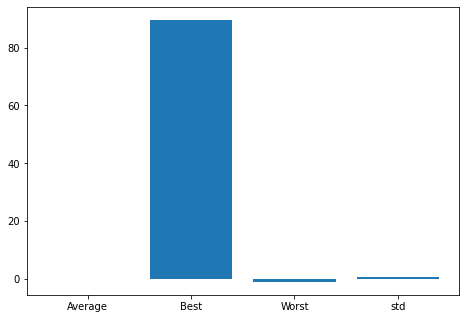

Average 3.4431589919347796%
Best 8956.603773584906%
Worst -98.48192771084338%
std 78.74111515871954%


In [575]:
#plot distribution of points by team 
avg = df['result'].mean()
best = df['result'].max()
worst = df['result'].min()
std = df['result'].std()

print(avg, best)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
stats = ['Average', 'Best', 'Worst', 'std']
columns = [avg, best, worst, std]
ax.bar(stats, columns)
plt.show()

for i in range(len(stats)):
  print(stats[i], f'{columns[i]*100}%')

### Machine learning part

- Drop all `NaN` values first. 
- Then split the dataset for test and training (using K-fold?). 
- Train the model
- Create a confusion matrix on the validation data. Compare results with reality



In [576]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

import logging

logging.getLogger('tensorflow').setLevel(logging.FATAL)
tf.autograph.set_verbosity(3)

In [577]:
# Shuffle the dataset
train_data, validation_data =  train_test_split(df, test_size=0.15, random_state=3456) 

# Split the dataset into features and target
X = train_data.drop(columns=['result', 'label'], axis=1).values
y = train_data['label'].values


In [578]:
# K-fold
num_folds = 7
# Define the k-fold cross-validator
kfold = KFold(n_splits=num_folds)

print(df.columns.values.tolist())

['Unnamed: 0', 'volume_stock', 'close_stock', 'zs-20-close_stock', 'ma-slope-20-close_stock', 'std-slope-20-close_stock', 'rng-20_stock', 'percent-rng-20-close_stock', 'percent-std-20-close_stock', 'kaufmanns_efficiency_ratio-20_stock', 'zs-50-close_stock', 'ma-slope-50-close_stock', 'std-slope-50-close_stock', 'rng-50_stock', 'percent-rng-50-close_stock', 'percent-std-50-close_stock', 'kaufmanns_efficiency_ratio-50_stock', 'zs-100-close_stock', 'ma-slope-100-close_stock', 'std-slope-100-close_stock', 'rng-100_stock', 'percent-rng-100-close_stock', 'percent-std-100-close_stock', 'kaufmanns_efficiency_ratio-100_stock', 'zs-200-close_stock', 'ma-slope-200-close_stock', 'std-slope-200-close_stock', 'rng-200_stock', 'percent-rng-200-close_stock', 'percent-std-200-close_stock', 'kaufmanns_efficiency_ratio-200_stock', 'zs-20-volume_stock', 'ma-slope-20-volume_stock', 'std-slope-20-volume_stock', 'percent-rng-20-volume_stock', 'percent-std-20-volume_stock', 'avg-log-volume-20_stock', 'zs-50-v

In [579]:
# Normalize input data
scaler = StandardScaler()

# Define TensorFlow model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [580]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

# Define learning rate scheduler callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.25)

# Calculate class weights based on occurrence since the base strategy loses more often we want to equalize the weights
class_weights = compute_class_weight('balanced', np.unique(y), y)

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

c:\Users\Bauhn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 1 1 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [581]:
# Train the model using k-fold cross-validation
for train_index, val_index in kfold.split(X):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Scale the data
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    # Train the model
    model.fit(X_train_fold_scaled, 
              y_train_fold, 
              epochs=1000, 
              batch_size=16, 
              validation_data=(X_val_fold_scaled, y_val_fold), 
              callbacks=[lr_scheduler, early_stopping],  
              class_weight=class_weights_dict 
            )
    print("hello")

Epoch 1/1000
780/780 [==============================] - 2s 1ms/step - loss: 0.7152 - accuracy: 0.5445 - val_loss: 0.6724 - val_accuracy: 0.5909 - lr: 0.0010
Epoch 2/1000
780/780 [==============================] - 1s 1ms/step - loss: 0.6833 - accuracy: 0.5810 - val_loss: 0.6692 - val_accuracy: 0.5928 - lr: 0.0010
Epoch 3/1000
780/780 [==============================] - 1s 1ms/step - loss: 0.6761 - accuracy: 0.5931 - val_loss: 0.6570 - val_accuracy: 0.6327 - lr: 0.0010
Epoch 4/1000
780/780 [==============================] - 1s 1ms/step - loss: 0.6669 - accuracy: 0.6115 - val_loss: 0.6752 - val_accuracy: 0.5923 - lr: 0.0010
Epoch 5/1000
780/780 [==============================] - 1s 1ms/step - loss: 0.6662 - accuracy: 0.6023 - val_loss: 0.6551 - val_accuracy: 0.6245 - lr: 0.0010
Epoch 6/1000
780/780 [==============================] - 1s 1ms/step - loss: 0.6621 - accuracy: 0.6179 - val_loss: 0.6603 - val_accuracy: 0.6197 - lr: 0.0010
Epoch 7/1000
780/780 [==============================] - 1s

In [582]:

# Scale the validation data with the same scaler used for the training data
validation_x = scaler.fit_transform(validation_data.drop(columns=['result', 'label'], axis=1).values)

# Run predictions on the validation dataset
y_pred = model.predict(validation_x)


In [583]:
tn, fp, fn, tp = confusion_matrix(validation_data['label'], np.where(y_pred > 0.5, 1, 0).flatten()).ravel()

accuracy = (tp+tn) / (tp+tn+fn+fp)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2 * (precision*recall)/(precision+recall)

print(f'accuracy: {accuracy} - precision: {precision} - recall: {recall} - f1 {f1}')

accuracy: 0.6348773841961853 - precision: 0.5061855670103093 - recall: 0.5168421052631579 - f1 0.5114583333333333


In [584]:
def summarize(df, name):
    winners = df[df['result'] >= 0]
    losers = df[df['result'] < 0]
    
    return pd.DataFrame.from_dict({
        'count': len(df),
        'avg': df['result'].mean(),
        'winrate': len(winners) / len(df),
        'avg_winner': winners['result'].mean(),
        'avg_loser': losers['result'].mean(),
        'total_win': winners['result'].sum(),
        'total_loss':  losers['result'].sum(),
        'profit_factor': winners['result'].sum() / -losers['result'].sum()
    }, orient='index', columns=[name])


In [585]:
res = validation_data[['result', 'label']].copy()
res['pred'] = y_pred

threshold = 0.5

all_trades = summarize(res, "all")
pred_winners = summarize(res[res['pred'] > threshold], "predicted winners")
pred_losers = summarize(res[res['pred'] <= threshold], "predicted losers")


pd.concat([all_trades, pred_winners, pred_losers,], axis=1)

,all,predicted winners,predicted losers
count,2569.000000,970.000000,1599.000000
avg,0.033677,0.120749,-0.019144
winrate,0.384196,0.512371,0.306442
avg_winner,0.295127,0.342731,0.246843
avg_loser,-0.129441,-0.112497,-0.136667
total_win,291.290120,170.337085,120.953035
total_loss,-204.774914,-53.210891,-151.564022
profit_factor,1.422489,3.201170,0.798033


#### 3456 - Benchmark innan Kaufman + trade count features
```csv
stat,all,predicted winners,predicted losers
count,2621.000000,1036.000000,1585.000000
avg,0.029182,0.112754,-0.025443
winrate,0.375048,0.519305,0.280757
avg_winner,0.296503,0.317832,0.270716
avg_loser,-0.131243,-0.108796,-0.141048
total_win,291.461980,170.993371,120.468609
total_loss,-214.975741,-54.180457,-160.795284
profit_factor,1.355790,3.155997,0.749205
```



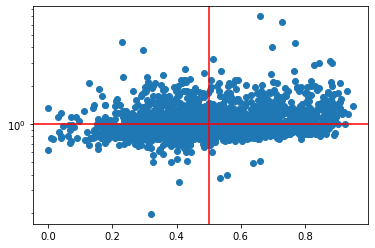

In [586]:
fig, ax = plt.subplots()
ax.scatter( res['pred'], res['result'] +1)
ax.set_yscale("log");
# ax.set_xscale("log");
# All above 1 is winners
plt.axhline(y=1, color='r', linestyle='-')
# All above threshold is predicted to be winners
plt.axvline(x=threshold, color='r', linestyle='-')
plt.show()

In [590]:
def divide(a, b):
    return b and a / b or 0

def getStats(inrange):
    winners = inrange[inrange['result'] >= 0]
    losers = inrange[inrange['result'] <= 0]
        
    d = {
        'winrate': divide(len(winners),len(inrange)),
        'profit_factor': divide(winners['result'].sum(), -losers['result'].sum())
    }
    return d

percentiles = []
percentiles_print = []
winrates_above = []
profitfactors_above = []
winrates_below = []
profitfactors_below = []

for i in range(10):
    in_range =res[res['pred'].between(i/10, (i+1)/10)]
    percentiles.append(i*10)
    percentiles_print.append(f'{i*10}: {len(in_range)}')

    # Probability Above i/10
    above = getStats(in_range)
    winrates_above.append(above['winrate'])
    profitfactors_above.append(above['profit_factor'])

    # Probability below i/10
    below = getStats(res[res['pred'] < i/10])
    winrates_below.append(below['winrate'])
    profitfactors_below.append(below['profit_factor'])

print(percentiles_print)
print(profitfactors_above)

['0: 21', '10: 58', '20: 250', '30: 606', '40: 664', '50: 389', '60: 250', '70: 192', '80: 122', '90: 17']
[0.3881372660175167, 0.7755111342273958, 0.6798787285021944, 0.7766147325958876, 0.8919591227882597, 1.5878893994858756, 3.123273338735743, 5.053368037794946, 10.397424076860737, 2057.322297275792]


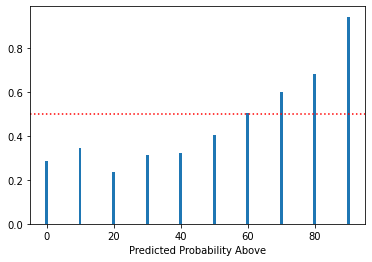

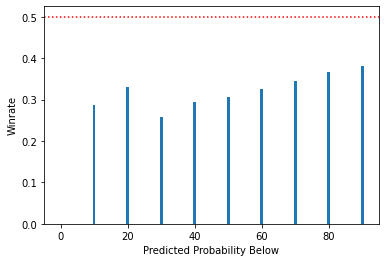

In [588]:
fig, ax1 = plt.subplots()
ax1.bar( percentiles, winrates_above)
plt.axhline(y=0.5, color='r', linestyle=':')
plt.xlabel('Predicted Probability Above')
fig2, ax2 = plt.subplots()
ax2.bar( percentiles, winrates_below)
plt.axhline(y=0.5, color='r', linestyle=':')
plt.xlabel('Predicted Probability Below')
plt.ylabel('Winrate')
plt.show()

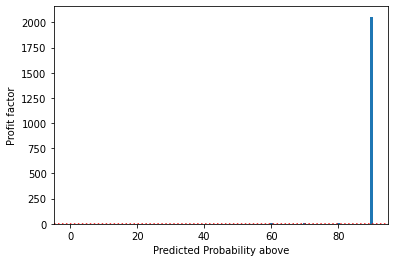

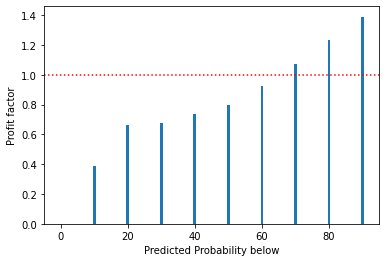

In [589]:
fig, ax = plt.subplots()
ax.bar( percentiles, profitfactors_above)
plt.axhline(y=1, color='r', linestyle=':')
plt.xlabel('Predicted Probability above')
plt.ylabel('Profit factor')

fig, ax2 = plt.subplots()
ax2.bar( percentiles, profitfactors_below)
plt.axhline(y=1, color='r', linestyle=':')
plt.xlabel('Predicted Probability below')
plt.ylabel('Profit factor')
plt.show()